In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import math
import scipy.special as sp
from aacgmv2 import convert_mlt, convert
from pyigrf12 import gridigrf12
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some constants
cutOffMLTMLATUniqCnt = 4
delLatDist = 111. * 1e3 # 1 deg lat is 111 km

In [3]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()
# Filter out some values
# When there aren't good number of measurements at lats
# discard those values
cntMLTPntsDF = velsDataDF[ ["dst_bin", "normMLT", "MLAT"] \
                    ].groupby( ["dst_bin", "normMLT"] \
                    )["MLAT"].nunique().reset_index()
cntMLTPntsDF.columns = ["dst_bin", "normMLT", "MLATCntUnq"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["MLATCntUnq"] >=\
                    cutOffMLTMLATUniqCnt ][ ["dst_bin", "normMLT"]\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, cntMLTPntsDF,\
                    on=["dst_bin", "normMLT"], how="inner" )
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [4]:
def get_geo_coords(row):
    if row["normMLT"] < 0: 
        currMLT = row["normMLT"] + 24.
    else:
        currMLT = row["normMLT"]
    currMlon = convert_mlt( currMLT, row["date"] , m2a=True )
    glat, glon = convert( row["MLAT"], currMlon , 300, row["date"], a2g=True)
    return str(glat) + "__" + str(glon)

velsDataDF["gcoord"] = velsDataDF.apply( get_geo_coords, axis=1 )
velsDataDF["glat"] = [ float( x.split("__")[0] ) for x in velsDataDF["gcoord"] ]
velsDataDF["glon"] = [ float( x.split("__")[1] ) for x in velsDataDF["gcoord"] ]

In [5]:
def get_efield(row):
    Bx,By,Bz,Bf, yeardec = gridigrf12( row["date"], 0, 1, 300., row["glat"], row["glon"] )
    Vy = row["vSaps"] * numpy.round( numpy.sin(numpy.deg2rad( row["azim"] )), 2 )
    Vx = row["vSaps"] * numpy.round( numpy.cos(numpy.deg2rad( row["azim"] )), 2 )
    Vz = 0.
    Ex = Bz[0] * -1 * Vy * 1e-9 # nT
    Ey = Bz[0] * Vx * 1e-9 # nT
    Ez = Bx[0] * Vy * 1e-9 - By[0] * Vx * 1e-9 # nT
    # Round electric fields by 2
    Ex = numpy.round( Ex * 1e3 , 4 ) # mV/m
    Ey = numpy.round( Ey * 1e3 , 4 ) # mV/m
    Ez = numpy.round( Ez * 1e3 , 4 ) # mV/m
    return str(Ex) + "__" + str(Ey) + "__" + str(Ez)

velsDataDF["Efield"] = velsDataDF.apply( get_efield, axis=1 )
velsDataDF["Ex"] = [ float( x.split("__")[0] ) for x in velsDataDF["Efield"] ]
velsDataDF["Ey"] = [ float( x.split("__")[1] ) for x in velsDataDF["Efield"] ]
velsDataDF["Ez"] = [ float( x.split("__")[2] ) for x in velsDataDF["Efield"] ]
velsDataDF["Efield"] = numpy.sqrt( numpy.square(velsDataDF["Ex"]) +\
                                 numpy.square(velsDataDF["Ey"]) +\
                                 numpy.square(velsDataDF["Ez"]))

In [6]:
# Asy Inds
asyDF = pandas.read_csv( "../data/Asy_processed.txt", sep=' ' )
asyDF["date"] = pandas.to_datetime(asyDF["datetimeStr"], format='%Y%m%d-%H-%M')
asyDF["hour"] = asyDF["date"].apply(lambda x: x.strftime('%H'))
asyDF["minute"] = asyDF["date"].apply(lambda x: x.strftime('%M'))
asyDF["dtStr"] = asyDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
asyDF.head()

,datetimeStr,AsyD,AsyH,SymD,SymH,date,hour,minute,dtStr
0,20110101-00-00,17.0,13.0,1.0,-10.0,2011-01-01 00:00:00,00,00,20110101
1,20110101-00-01,17.0,13.0,1.0,-10.0,2011-01-01 00:01:00,00,01,20110101
2,20110101-00-02,17.0,13.0,1.0,-10.0,2011-01-01 00:02:00,00,02,20110101
3,20110101-00-03,17.0,13.0,1.0,-10.0,2011-01-01 00:03:00,00,03,20110101
4,20110101-00-04,17.0,13.0,1.0,-10.0,2011-01-01 00:04:00,00,04,20110101


In [7]:
velsDataDF = pandas.merge( velsDataDF, asyDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
velsDataDF = velsDataDF [ ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date_x','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr_x', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH',\
                        'glat', 'glon', 'Efield', 'Ex', 'Ey', 'Ez'] ]
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH',\
                        'glat', 'glon', 'Efield', 'Ex', 'Ey', 'Ez']

In [8]:
# Divide asymH index into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH',\
                        'glat', 'glon', 'Efield', 'Ex', 'Ey', 'Ez', 'AsyH_bin']
velsDataDF.head()

,azim,azimStd,delMLT,goodFit,MLAT,normMLT,vSaps,velSTD,endPtMLAT,endPtNormMLT,...,AsyH,SymD,SymH,glat,glon,Efield,Ex,Ey,Ez,AsyH_bin
0,-79.412573,1.794202,0.5,True,62.0,-6.0,306.738497,11.198685,62.06,-6.30,...,33.0,2.0,-48.0,52.550383,-100.904280,15.307472,14.6255,2.6863,-3.6328,"(30, 60]"
1,-78.075135,1.005434,0.5,True,61.5,-6.0,296.893207,6.211472,61.56,-6.29,...,33.0,2.0,-48.0,52.025938,-100.963274,14.864103,14.0997,3.0214,-3.6071,"(30, 60]"
2,-82.467569,3.532155,0.5,True,60.0,-6.0,220.239731,11.464162,60.03,-6.22,...,33.0,2.0,-48.0,50.455151,-101.132638,10.899579,10.4296,1.3695,-2.8546,"(30, 60]"
3,-84.987310,1.491959,0.5,True,60.5,-6.0,233.815511,5.963564,60.52,-6.23,...,33.0,2.0,-48.0,50.978340,-101.077372,11.668698,11.2349,1.0111,-2.9855,"(30, 60]"
4,-79.086184,0.914397,0.5,True,62.5,-6.0,343.746070,6.854657,62.57,-6.34,...,33.0,2.0,-48.0,53.075283,-100.843875,17.226031,16.4528,3.1898,-3.9833,"(30, 60]"


In [9]:
mltVelsVarsDF = velsDataDF[ ["normMLT", "MLAT","AsyH", "vSaps", "Efield"] \
                    ].groupby( ["normMLT", "MLAT", "AsyH"] ).mean().reset_index()
mltVelsVarsDF.columns = ["normMLT", "MLAT", "AsyH", "mean_vel", "mean_efld"]
stdVelsVarsDF = velsDataDF[ ["normMLT", "MLAT", "AsyH", "vSaps", "Efield"] \
                    ].groupby( ["normMLT", "MLAT", "AsyH"] ).std().reset_index()
stdVelsVarsDF.columns = ["normMLT", "MLAT", "AsyH", "std_vel", "std_efld"]
mltVelsVarsDF = pandas.merge( mltVelsVarsDF, stdVelsVarsDF, on=["normMLT", "MLAT", "AsyH"] )
mltVelsVarsDF = mltVelsVarsDF.dropna().reset_index(drop=True)
mltVelsVarsDF.head()

,normMLT,MLAT,AsyH,mean_vel,mean_efld,std_vel,std_efld
0,-7.0,56.5,45.0,829.628010,39.753414,0.000000,0.000000
1,-7.0,56.5,57.0,991.448460,47.438951,269.059502,13.011549
2,-7.0,56.5,59.0,834.758663,39.974980,0.000000,0.000000
3,-7.0,56.5,65.0,813.083889,38.995522,32.459748,1.497855
4,-7.0,56.5,66.0,836.770482,40.021007,0.000000,0.000000


In [10]:
# Arrays to store potential
potBinArr = []
potNrmMltArr = []
potMlatArr = []
potPotArr = []
# get uniq bins
for cbin in mltVelsVarsDF["AsyH"].unique():
    # sel data only from the bin
    selLocsDF = mltVelsVarsDF[ mltVelsVarsDF["AsyH"] == cbin ]
    for cmlt in selLocsDF["normMLT"].unique().tolist():
        # Get Uniq Lats at the MLT!
        selMltDF = selLocsDF[ selLocsDF["normMLT"] == cmlt ]
        # At each MLT we assume potential is zero at the lowest
        # latitude!
        prevPot = 0
        for cMlat in sorted( selMltDF["MLAT"].unique().tolist() ):
            selLatsDF = selMltDF[ (selMltDF["MLAT"] == cMlat) ]
            # Remember we have 0.5 deg latitude res
            # so we take delLatDist/2
            potLat = selLatsDF[ selLatsDF["MLAT"] == cMlat ]["mean_efld"] * delLatDist/2. * 1e-3 * 1e-3 # kV
            currPot = prevPot - potLat.values[0]
            prevPot = currPot
            potBinArr.append( cbin )
            potNrmMltArr.append( cmlt )
            potMlatArr.append( cMlat )
            potPotArr.append( round(currPot,2) )
            
# Store the results in a DF
potentialDF = pandas.DataFrame({
            "AsyH" : potBinArr,
            "normMLT" : potNrmMltArr,
            "MLAT" : potMlatArr,
            "potential" : potPotArr
            })
potentialDF["normLAT"] = potentialDF["MLAT"] - 58.5 # get a normalized latitude for better fits
potentialDF["potMagn"] = numpy.abs( potentialDF["potential"] )
potentialDF.head()

,AsyH,MLAT,normMLT,potential,normLAT,potMagn
0,45.0,56.5,-7.0,-2.21,-2.0,2.21
1,45.0,57.0,-7.0,-3.82,-1.5,3.82
2,45.0,57.5,-7.0,-5.75,-1.0,5.75
3,45.0,58.5,-7.0,-7.77,0.0,7.77
4,45.0,59.0,-7.0,-10.10,0.5,10.10


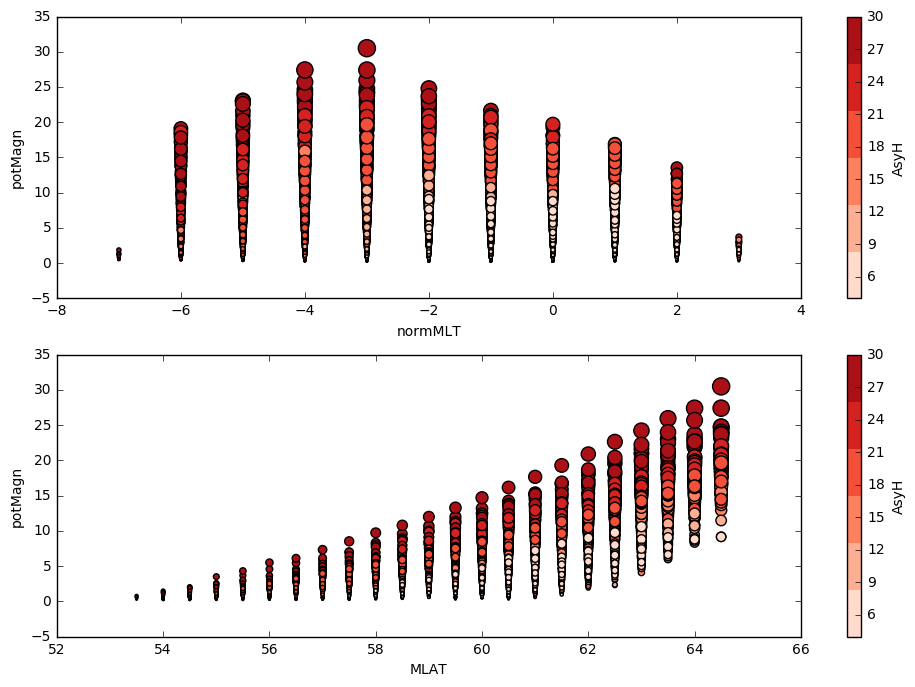

In [19]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(2,1,1)
ax2 = f.add_subplot(2,1,2)
seaMap = ListedColormap(sns.color_palette("Reds"))
pltDF = potentialDF[ potentialDF["AsyH"] <= 30. ]
pltDF.plot( kind='scatter',
              x='normMLT',
              y='potMagn',
              c='AsyH',
              s=pltDF["potential"]*-5, cmap=seaMap, ax=ax1)

pltDF.plot( kind='scatter',
              x='MLAT',
              y='potMagn',
              c='AsyH',
              s=pltDF["potential"]*-5, cmap=seaMap, ax=ax2)
f.savefig("../figs/potLocTest.pdf",bbox_inches='tight')

In [154]:
# get the fitting function
# We'll use fourier series (first order)
# to fit MLTs and we'll use a linear function
# to fit MLATs.
def pot_fit_func( (mlt,mlat, asy),\
                 mlt_a0, mlt_c1, mlt_s1, mlt_phiC1, mlt_phiS1,\
                a_amlat, b_amlat, a_bmlat, b_bmlat):
    # mlat func
    a_mlat = a_amlat + b_amlat * asy
    b_mlat = a_bmlat + b_bmlat * asy
    mlatFunc = a_mlat + b_mlat*(mlat)
    # mlt func
    phiC = (2*numpy.pi/24.) * mlt + mlt_phiC1
    phiS = (2*numpy.pi/24.) * mlt + mlt_phiS1
    cosTerm = asy*mlt_c1 * numpy.cos(phiC)
    sinTerm = asy*mlt_s1 * numpy.sin(phiS)
    mltFunc = asy*mlt_a0 + cosTerm + sinTerm
    
    return mlatFunc*mltFunc

In [163]:
fitPotDF = potentialDF.reset_index(drop=True)
# get actual MLTs
fitPotDF["mlt"] = [ x if x > 0. else x+24. for x in fitPotDF["normMLT"] ]
# Normalize potential data. Ideally it 
# should vary between -1 and +1. This
# makes modelling easy since we are 
# using a periodic funciton!!!
normMaxPot = fitPotDF['potMagn'].max()
normMeanPot = fitPotDF['potMagn'].mean()
fitPotDF["potNorm"] = fitPotDF['potMagn']/normMaxPot
fitPotDF['potNorm'] = fitPotDF['potNorm'] - normMeanPot

initGuess = (1., 1., 1., 1.,\
             1., 1., 1., 1., 1.)

poptPots, pcovPots = curve_fit(pot_fit_func,\
                               (fitPotDF['mlt'].T,fitPotDF['MLAT'].T,fitPotDF['AsyH'].T),\
                               fitPotDF['potNorm'], p0=initGuess)

# get the predicted esimtes
predMltArr = []
predMlatArr = []
predAsyArr = []
predPotArr = []
predNormMltArr = []
for cpMlt in range(25):
    for cpMlat in range(50,71):
        for cpAsy in range(0,200):
            predMltArr.append( cpMlt )
            if cpMlt <= 12:
                predNormMltArr.append( cpMlt )
            else:
                predNormMltArr.append( cpMlt-24 )
            predMlatArr.append( cpMlat )
            predAsyArr.append( cpAsy )
            predPotArr.append( pot_fit_func(\
                                        (cpMlt, cpMlat, cpAsy), *poptPots) )

predPotDF = pandas.DataFrame({
                "predMlt" : predMltArr,
                "predNormMlt" : predNormMltArr,
                "predMlat" : predMlatArr,
                "predAsy" : predAsyArr,
                "predPot" : predPotArr
                })
# denormalize the potential
predPotDF["predPot"] = predPotDF["predPot"] + normMeanPot
predPotDF["predPot"] = predPotDF["predPot"] * normMaxPot

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


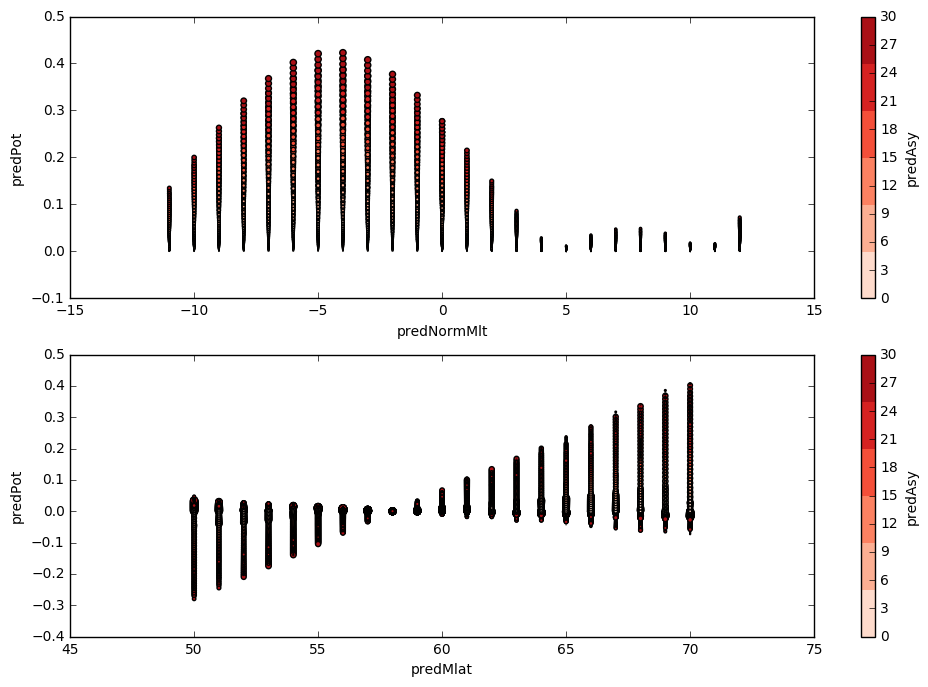

In [165]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(2,1,1)
ax2 = f.add_subplot(2,1,2)
seaMap = ListedColormap(sns.color_palette("Reds"))
subpredPotDF = predPotDF[ predPotDF["predAsy"] <= 30. ]

subpredPotDF.plot( kind='scatter',
              x='predNormMlt',
              y='predPot',
              c='predAsy',
              s=subpredPotDF["predPot"]*50, cmap=seaMap, ax=ax1)

subpredPotDF.plot( kind='scatter',
              x='predMlat',
              y='predPot',
              c='predAsy',
              s=predPotDF["predPot"]*50, cmap=seaMap, ax=ax2)

In [141]:
# To estimate the boundary we
# fit first order harmonics!
def mlt_fit_harmonic(mlt, a0, c1, s1, phiC1, phiS1):
    phiC = (2*numpy.pi/24.) * mlt + phiC1
    phiS = (2*numpy.pi/24.) * mlt + phiS1
    cosTerm = c1 * numpy.cos(phiC)
    sinTerm = s1 * numpy.sin(phiS)
#     cos2Term = c2 * numpy.cos(2*phiC)
#     sin2Term = s2 * numpy.sin(2*phiS)
    return a0 + cosTerm + sinTerm# + cos2Term + sin2Term

(-12, 12)

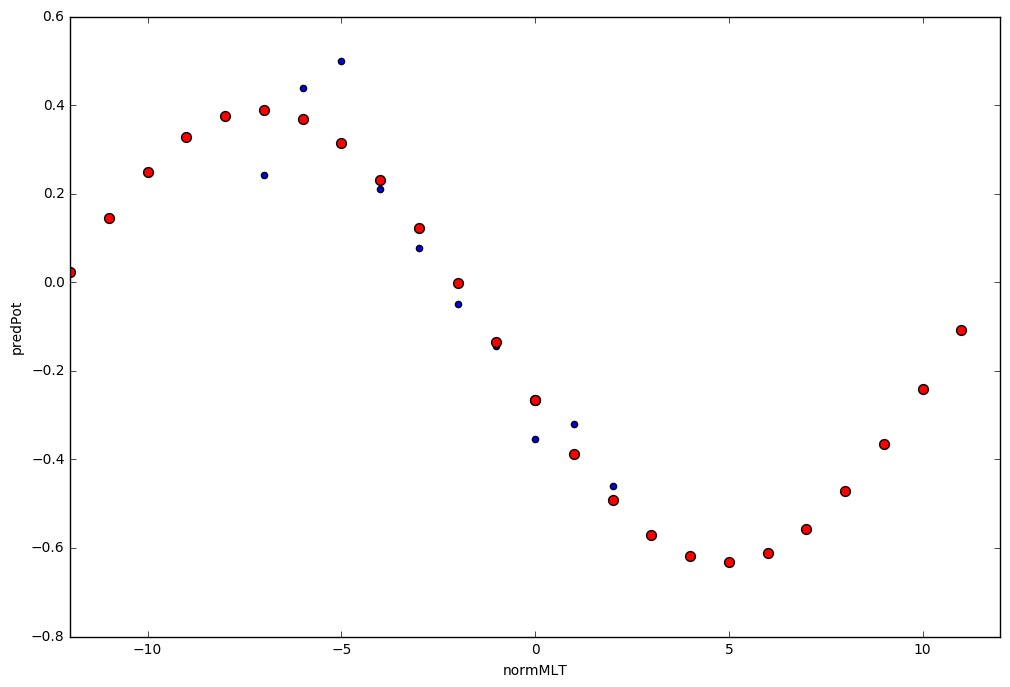

In [147]:
testDF = potentialDF[ (potentialDF["AsyH"] >= 90.) &\
                     (potentialDF["AsyH"] < 180.) \
                    ].reset_index(drop=True)
testDF["mlt"] = [ x if x > 0. else x+24. for x in testDF["normMLT"] ]

testMedDF = testDF.groupby( "normMLT" ).median().reset_index()
# Normalize potential data. Ideally it 
# should vary between -1 and +1. This
# makes modelling easy since we are 
# using a periodic funciton!!!
testMedDF['potMagn'] = testMedDF['potMagn']/testMedDF['potMagn'].max()
testMedDF['potMagn'] = testMedDF['potMagn']-0.5#/testMedDF['potMagn'].abs().max()
poptTest, pcovTest = curve_fit( mlt_fit_harmonic, testMedDF["mlt"].values,\
                                   testMedDF["potMagn"].values,\
                               p0 = [1., 1., 1., 1., 1.] )
# get pred values
predMltArr = []
predPotArr = []

for cpMlt in range(25):
    predMltArr.append( cpMlt )
    predPotArr.append( mlt_fit_harmonic(\
                                cpMlt, *poptTest) )

predPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLT" : predMltArr
                })
                

predPotDF["normMLT"] = [ x if x < 12. else x-24. for x in predPotDF["predMLT"] ]
    
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
testMedDF.plot( kind='scatter',
              x='normMLT',
              y='potMagn',ax=ax)

predPotDF.plot( kind='scatter',
              x='normMLT',
              y='predPot',ax=ax, s=50.0, c='r')

ax.set_xlim( [ -12, 12 ] )

In [134]:
x = testMedDF['potMagn']#-testMedDF['potMagn'].mean()
print x#.abs()# - x.median()

0     0.900
1     3.610
2     4.720
3     6.370
4     6.445
5     5.940
6     6.045
7     5.450
8     5.880
9     4.630
10    1.570
Name: potMagn, dtype: float64


In [135]:
print testMedDF['potMagn'] - aa

0     3.054642
1     4.222878
2     4.701381
3     5.412669
4     5.445000
5     5.227303
6     5.272567
7     5.016072
8     5.201438
9     4.662583
10    3.343468
Name: potMagn, dtype: float64


In [137]:
aa = testMedDF['potMagn']/testMedDF['potMagn'].max()
normFactor = 0.5#aa.abs().max()
print aa-normFactor

0    -0.360357
1     0.060124
2     0.232351
3     0.488363
4     0.500000
5     0.421645
6     0.437936
7     0.345617
8     0.412335
9     0.218386
10   -0.256400
Name: potMagn, dtype: float64
